In [112]:
from graphviz import Digraph
import math

# Função para Criar Grafos

In [118]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s|data %.4f| grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# AutoGrad


A ideia das funções _backward() é definir como as variáveis que foram operadas para produzir uma nova variável devem afetar o gradiente durante o backpropagation.

* Adição (__add__): O gradiente de cada operando é simplesmente o gradiente da saída multiplicado por 1.
* Multiplicação (__mul__): O gradiente de cada operando é o gradiente da saída multiplicado pelo valor do outro operando.
* Tangente Hiperbólica (tanh): O gradiente do operando é o gradiente da saída multiplicado pela derivada da tangente hiperbólica.

In [123]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t * t) * out.grad
        out._backward = _backward
        
        return out

In [124]:
# Criação dos objetos
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")
b = Value(6.881373, label="b")

# Operações
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

# Definição do gradiente da saída final
o.grad = 1

# Chamada do backward
o._backward()
print(o._prev)

print(id(n))

{Value(data=0.881373, label=n)}
2508895462096


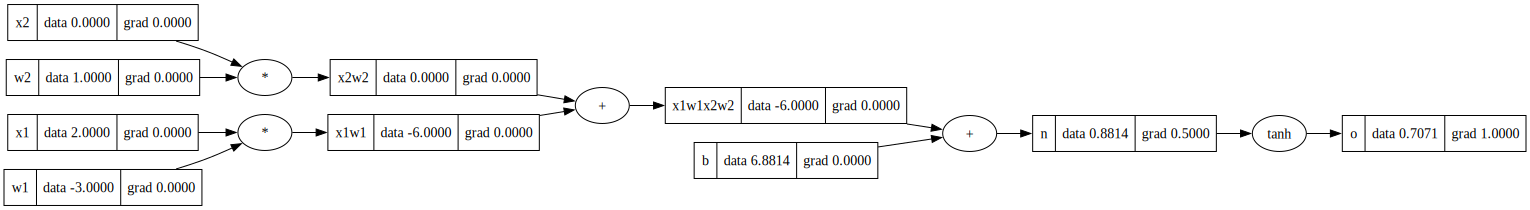

In [125]:
draw_dot(o)

In [107]:
o.grad = 1

In [108]:
o._backward

<function __main__.Value.tanh.<locals>._backward_f()>

In [109]:
o._backward()

0.0
0.7071064876766542
1


In [103]:
def teste():
 return "banana"

In [130]:
topo = []
visited = []
def build_topo(v):
    if v not in visited:
        visited.append(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    

In [131]:
build_topo(o)

In [132]:
visited

[Value(data=0.7071064876766542, label=o),
 Value(data=0.881373, label=n),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=0.0, label=x2w2),
 Value(data=0.0, label=x2),
 Value(data=1, label=w2),
 Value(data=-6, label=x1w1),
 Value(data=2, label=x1),
 Value(data=-3, label=w1),
 Value(data=6.881373, label=b)]

In [133]:
topo

[Value(data=0.0, label=x2),
 Value(data=1, label=w2),
 Value(data=0.0, label=x2w2),
 Value(data=2, label=x1),
 Value(data=-3, label=w1),
 Value(data=-6, label=x1w1),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=6.881373, label=b),
 Value(data=0.881373, label=n),
 Value(data=0.7071064876766542, label=o)]